In [1]:
from tinyphysics import TinyPhysicsModel, TinyPhysicsSimulator, CONTROL_START_IDX
from controllers import pid, BaseController
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_theme()


In [2]:
from typing import List
from collections import namedtuple

State = namedtuple('State', ['roll_lataccel', 'v_ego', 'a_ego'])

class MyPhysicsModel(TinyPhysicsModel):
    def __init__(self, model_path: str, debug: bool) -> None:
        super().__init__(model_path, debug)
        
    def get_current_lataccel(self, sim_states: List[State], actions: List[float], past_preds: List[float]) -> float:
        tokenized_actions = self.tokenizer.encode(past_preds)
        raw_states = [list(x) for x in sim_states]
        states = np.column_stack([actions, raw_states])
        input_data = {
          'states': np.expand_dims(states, axis=0).astype(np.float32),
          'tokens': np.expand_dims(tokenized_actions, axis=0).astype(np.int64)
        }
        return self.tokenizer.decode(self.predict(input_data, temperature=0.0001))

In [3]:
ACC_G = 9.81
FPS = 10
CONTROL_START_IDX = 100
COST_END_IDX = 500
CONTEXT_LENGTH = 20
VOCAB_SIZE = 1024
LATACCEL_RANGE = [-5, 5]
STEER_RANGE = [-2, 2]
MAX_ACC_DELTA = 0.5
DEL_T = 0.1
LAT_ACCEL_COST_MULTIPLIER = 50.0

FUTURE_PLAN_STEPS = FPS * 5  # 5 secs
from typing import List, Union, Tuple
import pandas as pd
from collections import namedtuple

FuturePlan = namedtuple('FuturePlan', ['lataccel', 'roll_lataccel', 'v_ego', 'a_ego'])

class MySimulator(TinyPhysicsSimulator):
    
    def __init__(self, model: TinyPhysicsModel, data_path: str, controller: BaseController, debug: bool = False) -> None:
        super().__init__(model, data_path, controller, debug)
        
        
    def sim_step(self, step_idx: int, force_action=False) -> None:
        try:
            pred = self.sim_model.get_current_lataccel(
              sim_states=self.state_history[-CONTEXT_LENGTH:],
              actions=self.action_history[-CONTEXT_LENGTH:],
              past_preds=self.current_lataccel_history[-CONTEXT_LENGTH:]
            )
        except:
            print(self.state_history[-CONTEXT_LENGTH:], self.action_history[-CONTEXT_LENGTH:], self.current_lataccel_history[-CONTEXT_LENGTH:])
        pred = np.clip(pred, self.current_lataccel - MAX_ACC_DELTA, self.current_lataccel + MAX_ACC_DELTA)
        if step_idx >= CONTROL_START_IDX or force_action:
            self.current_lataccel = pred
        else:
            self.current_lataccel = self.get_state_target_futureplan(step_idx)[1]
        self.current_lataccel_history.append(self.current_lataccel)

        
    def control_step(self, step_idx: int, steer_action: float, force_action=False) -> None:
        #action = self.controller.update(self.target_lataccel_history[step_idx], self.current_lataccel, self.state_history[step_idx], future_plan=self.futureplan)
        #if force_action or (step_idx >= CONTROL_START_IDX and steer_action is not None and not pd.isna(steer_action)):
        if step_idx >= CONTROL_START_IDX and steer_action is not None:
            action = steer_action
        else:
            action = self.data['steer_command'].values[step_idx]
        action = np.clip(action, STEER_RANGE[0], STEER_RANGE[1])
        self.action_history.append(action)
        
    def get_state_target_futureplan(self, step_idx: int) -> Tuple[State, float]:
        state = self.data.iloc[step_idx]
        return (
            State(roll_lataccel=state['roll_lataccel'], v_ego=state['v_ego'], a_ego=state['a_ego']),
            state['target_lataccel'],
            FuturePlan(
                lataccel=self.data['target_lataccel'].values[step_idx + 1 :step_idx + FUTURE_PLAN_STEPS].tolist(),
                roll_lataccel=self.data['roll_lataccel'].values[step_idx + 1 :step_idx + FUTURE_PLAN_STEPS].tolist(),
                v_ego=self.data['v_ego'].values[step_idx + 1 :step_idx + FUTURE_PLAN_STEPS].tolist(),
                a_ego=self.data['a_ego'].values[step_idx + 1 :step_idx + FUTURE_PLAN_STEPS].tolist()
            )
        )
        
    def step(self, steer_action=None, force_action=False) -> None:
        state, target, futureplan = self.get_state_target_futureplan(self.step_idx)
        self.state_history.append(state)
        self.target_lataccel_history.append(target)
        self.futureplan = futureplan
        self.control_step(self.step_idx, steer_action, force_action)
        self.sim_step(self.step_idx, force_action)
        self.step_idx += 1
        
    def reverse_step(self) -> None:
        self.step_idx -= 1
        self.state_history.pop()
        self.target_lataccel_history.pop()
        self.action_history.pop()
        self.current_lataccel_history.pop()
        state, target, futureplan = self.get_state_target_futureplan(self.step_idx)
        self.futureplan = futureplan
        self.current_lataccel = self.current_lataccel_history[-1]
        
    def compute_cost(self, unit=False) -> dict:
        if unit:
            target = np.array(self.target_lataccel_history)[self.step_idx - 2:self.step_idx]
            pred = np.array(self.current_lataccel_history)[self.step_idx - 2:self.step_idx]
        else:
            target = np.array(self.target_lataccel_history)[CONTROL_START_IDX:COST_END_IDX]
            pred = np.array(self.current_lataccel_history)[CONTROL_START_IDX:COST_END_IDX]
            
        lat_accel_cost = np.mean((target - pred)**2) * 100
        jerk_cost = np.mean((np.diff(pred) / DEL_T)**2) * 100
            
        total_cost = (lat_accel_cost * LAT_ACCEL_COST_MULTIPLIER) + jerk_cost
        return {'lataccel_cost': lat_accel_cost, 'jerk_cost': jerk_cost, 'total_cost': total_cost}

In [4]:
class BaselineRecord:
    
    def __init__(self, baseline):
        self.current_lataccel_history = baseline.current_lataccel_history
        self.target_lataccel_history = baseline.target_lataccel_history
        self.state_history = baseline.state_history
        self.action_history = baseline.action_history
        self.cost = baseline.compute_cost()
    
    def compute_cost(self):
        return self.cost

In [20]:
import pickle

with open('baselines.pkl', 'rb') as handle:
    baselines = pickle.load(handle)

In [5]:
def plot_rollout(sim):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(sim.target_lataccel_history, label="Target Lateral Acceleration", alpha=0.5)
    ax.plot(sim.current_lataccel_history, label="Actual Lateral Acceleration", alpha=0.5)
    ax.legend()
    ax.set_xlabel("Step")
    ax.set_ylabel("Lateral Acceleration")
    ax.set_title("Rollout")
    plt.show()

In [121]:
driving_model = TinyPhysicsModel("./models/tinyphysics.onnx", debug=True)

In [6]:
driving_model = MyPhysicsModel("./models/tinyphysics.onnx", debug=True)

In [9]:
model = TinyPhysicsModel("./models/tinyphysics.onnx", debug=True)
controller = pid.Controller()

In [80]:
testController2 = Controller()

In [34]:
testController2 = Controller()
noisy_driving_model = TinyPhysicsModel("./models/tinyphysics.onnx", debug=True)
sim = TinyPhysicsSimulator(noisy_driving_model, "./data/02675.csv", controller=testController2, debug=False)
sim.rollout()

{'lataccel_cost': 10.977058512086137,
 'jerk_cost': 70.9973176851279,
 'total_cost': 619.8502432894347}

In [83]:
sim.compute_cost()

{'lataccel_cost': 4.603215606361677,
 'jerk_cost': 50.25324543967904,
 'total_cost': 280.4140257577629}

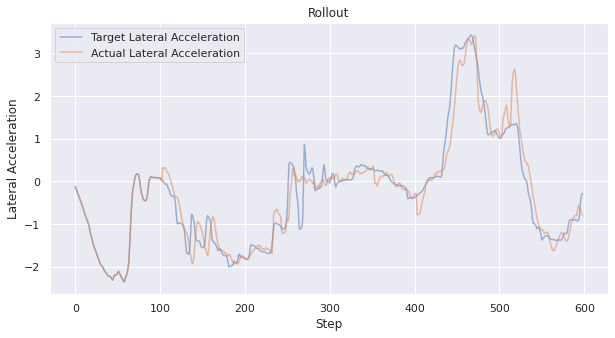

In [39]:
plot_rollout(sim)

In [10]:
from controllers import BaseController
import numpy as np
class Controller(BaseController):
  """
  A simple PID controller
  """
  def __init__(self,):
    self.p = 0.085
    self.i = 0.11
    self.d = -0.0
    self.error_integral = 0
    self.prev_error = 0
    self.n_updates= 0

  def update(self, target_lataccel, current_lataccel, state, future_plan):
      error = (target_lataccel - current_lataccel)
      self.error_integral += error
      error_diff = error - self.prev_error
      self.prev_error = error
      p = self.p
      i = self.i
      d = self.d
      self.n_updates += 1
      return p * error + i * self.error_integral + d * error_diff

# RL

In [7]:
from tqdm import tqdm
import pandas as pd
dfs = []
to_load = 1
for i in tqdm(range(to_load), total=to_load):
    num_str = str(i)
    while len(num_str) < 5:
        num_str = '0' + num_str
    try:
        temp = pd.read_csv(f'/notebooks/comma/controls_challenge/data/{num_str}.csv', sep=',')
    except:
        print(f'data/{num_str}.csv does not exist')
    dfs.append(temp)
df = pd.concat(dfs)
df['shifted_target'] = df['targetLateralAcceleration'].shift(1).fillna(0)
df.head()

100%|██████████| 1/1 [00:00<00:00, 128.75it/s]


,t,vEgo,aEgo,roll,targetLateralAcceleration,steerCommand,shifted_target
0,0.0,33.770260,-0.017300,0.037470,1.003864,-0.329734,0.000000
1,0.1,33.763533,-0.039069,0.037006,1.049681,-0.335021,1.003864
2,0.2,33.755949,-0.067940,0.036543,1.056292,-0.332706,1.049681
3,0.3,33.758334,-0.022276,0.036579,1.051750,-0.336199,1.056292
4,0.4,33.752904,-0.052032,0.036652,1.059831,-0.352662,1.051750


In [7]:
df.describe()

,t,vEgo,aEgo,roll,targetLateralAcceleration,steerCommand,shifted_target
count,600.000000,600.000000,600.000000,600.000000,600.000000,100.000000,600.000000
mean,29.950000,33.612789,-0.003472,0.000205,0.178489,-0.172597,0.178594
std,17.334936,0.202384,0.107305,0.032123,0.689039,0.137597,0.689007
min,0.000000,32.871269,-0.293251,-0.050939,-1.101664,-0.365672,-1.101664
25%,14.975000,33.580512,-0.066254,-0.020199,-0.123345,-0.285788,-0.123345
50%,29.950000,33.639732,-0.005913,-0.010522,0.025921,-0.187684,0.025921
75%,44.925000,33.696109,0.051604,0.036263,0.888899,-0.025493,0.888899
max,59.900000,33.957455,0.449283,0.048287,1.112067,0.033607,1.112067


In [8]:
from typing import Callable

def linear_schedule(initial_value: float) -> Callable[[float], float]:
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return progress_remaining * initial_value

    return func

In [26]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces
import random


class DriverEnv(gym.Env):
    """Custom Environment that follows gym interface."""

    metadata = {"render_modes": ["console"]}

    def __init__(self, driving_model, filenames=None, baselines=None):
        super().__init__()
        self.action_space = spaces.Box(
            low = -1, high = 1, shape = (1,), dtype = np.float32
        )
        self.driving_model = driving_model
        self.physics_simulator = None
        self.data = None
        self.file_n = 0
        self.baseline_simulator = None
        self.filenames = filenames
        self.baselines = baselines if baselines is not None else {}
        self.exploration_done = True
        self.observation_space = spaces.Dict(
            spaces={
                'CURRENT_INFO': spaces.Box(low=-np.inf, high=np.inf, shape=(11,)),
                'CURRENT_LATACCEL_DIFF': spaces.Box(low=-np.inf, high=np.inf, shape=(49,)),
                'FUTURE_LATACCEL': spaces.Box(low=-np.inf, high=np.inf, shape=(49,)),
                'FUTURE_ROLL': spaces.Box(low=-np.inf, high=np.inf, shape=(49,)),
                'FUTURE_VEL': spaces.Box(low=-np.inf, high=np.inf, shape=(49,)),
                'FUTURE_A': spaces.Box(low=-np.inf, high=np.inf, shape=(49,)),
                'PAST_LATACCEL': spaces.Box(low=-np.inf, high=np.inf, shape=(20,)),
                'PAST_ACTIONS': spaces.Box(low=-np.inf, high=np.inf, shape=(20,)),
                'PAST_ROLL': spaces.Box(low=-np.inf, high=np.inf, shape=(20,)),
                'PAST_VEL': spaces.Box(low=-np.inf, high=np.inf, shape=(20,)),
                'PAST_A': spaces.Box(low=-np.inf, high=np.inf, shape=(20,))
            })
        
    def calculate_cost(self, target, pred, prev_current_lataccel):
        lat_accel_cost = (target - pred)**2 * 100
        jerk_cost = ((pred - prev_current_lataccel) / DEL_T)**2 * 100
            
        total_cost = (lat_accel_cost * LAT_ACCEL_COST_MULTIPLIER) + jerk_cost
        return total_cost
    
    def update_array(self, array, newVal, limit=20):
        array = np.append(array, newVal)
        if len(array) > limit:
            array = np.delete(array, 0)
        return array
    
    def step(self, action):
        prev_current_lataccel = self.physics_simulator.current_lataccel_history[self.physics_simulator.step_idx - 1]
        baseline_prev_current_lataccel = self.baseline_simulator.current_lataccel_history[self.physics_simulator.step_idx - 1]
        prev_target_lataccel = self.physics_simulator.get_state_target_futureplan(self.physics_simulator.step_idx)[1]
        act = action[0]*2
        last_action = self.last_actions[-1] if len(self.last_actions) > 0 else act

        self.physics_simulator.step(act)
        current_lataccel = self.physics_simulator.current_lataccel_history[self.physics_simulator.step_idx - 1]
        baseline_current_lataccel = self.baseline_simulator.current_lataccel_history[self.physics_simulator.step_idx - 1]
        
        terminated = self.physics_simulator.step_idx == COST_END_IDX - 1
        if terminated:
            print(f'cost for {self.filename} is {self.physics_simulator.compute_cost()}')
            s = self.physics_simulator.get_state_target_futureplan(self.physics_simulator.step_idx - 1)
        else:
            s = self.physics_simulator.get_state_target_futureplan(self.physics_simulator.step_idx)
            
        state = s[0]
        target_lataccel = s[1]
        future = FuturePlan(
            lataccel=s[2].lataccel if len(s[2].lataccel) > 0 else [current_lataccel],
            roll_lataccel=s[2].roll_lataccel if len(s[2].roll_lataccel) > 0 else [state.roll_lataccel],
            v_ego=s[2].v_ego if len(s[2].v_ego) > 0 else [state.v_ego],
            a_ego=s[2].a_ego if len(s[2].a_ego) > 0 else [state.a_ego]
        )
        
        self.last_actions = self.update_array(self.last_actions, act, 10)
        error = target_lataccel - current_lataccel
        self.error_integral += error
        error_diff = error - self.prev_error
        self.prev_error = error
        pid_action = error*0.085 + self.error_integral*0.11
        
        action_diff = act - last_action
            
        delta_cost = 0
        actual_cost = self.calculate_cost(self.physics_simulator.target_lataccel_history[-1], current_lataccel, prev_current_lataccel)
        baseline_cost = self.calculate_cost(self.physics_simulator.target_lataccel_history[-1], baseline_current_lataccel, baseline_prev_current_lataccel)
        reward = baseline_cost - actual_cost
        if abs(action_diff) > 0.3:
            delta_cost = abs(action_diff)
            reward -= delta_cost*1000
            
        self.rewards = np.append(self.rewards, reward)
        future_diffs = np.diff(np.array(future.lataccel))
        observation = {
            'CURRENT_INFO': np.array([
                target_lataccel, current_lataccel, action_diff, last_action,
                error, self.prev_error, np.clip(self.error_integral, 100, -100),
                np.mean((np.diff(np.array(future.lataccel[:10])) / DEL_T)**2), np.mean((future_diffs / DEL_T)**2),
                np.mean(future.lataccel[:10]), np.mean(future.lataccel),
            ]), 
            'CURRENT_LATACCEL_DIFF': np.array(future.lataccel - current_lataccel), 
            'FUTURE_LATACCEL': np.array(future.lataccel), 
            'FUTURE_ROLL':np.array(future.roll_lataccel), 
            'FUTURE_VEL':np.array(future.v_ego), 
            'FUTURE_A':np.array(future.a_ego),
            'PAST_LATACCEL':np.array(self.physics_simulator.current_lataccel_history[-19:] + [current_lataccel]),
            'PAST_ACTIONS': np.array(self.physics_simulator.action_history[-20:]),
            'PAST_ROLL': np.array([s.roll_lataccel for s in self.physics_simulator.state_history[-19:]] + [state.roll_lataccel]),
            'PAST_VEL': np.array([s.v_ego for s in self.physics_simulator.state_history[-19:]] + [state.v_ego]),
            'PAST_A': np.array([s.a_ego for s in self.physics_simulator.state_history[-19:]] + [state.a_ego]),
        }

        if terminated:
            #print(pd.DataFrame(self.observations).describe())
            print(reward, np.mean(self.rewards))
            return observation, reward, terminated, False, {}

        truncated = False
        info = {}
            
        return observation, reward, terminated, truncated, info

    def reset(self, seed=None, options=None):
        self.filename = None
        self.filename = self.filenames[self.file_n]
        self.file_n += 1
        #n_file = random.randint(0, len(self.filenames) - 1)
        #self.filename = self.filenames[n_file]
            
        if self.filenames is None:
            #n_file = random.randint(0, 20000)
            n_file = self.file_n
            num_str = str(n_file)
            while len(num_str) < 5:
                num_str = '0' + num_str
            self.filename = f'/notebooks/comma/controls_challenge/data/{num_str}.csv'

        if self.file_n >= 20_000 or (self.filenames is not None and self.file_n >= len(self.filenames)):
            self.file_n = 0
        self.data = pd.read_csv(self.filename, sep=',')
        self.cum_error = 0
        self.prev_error = 0
        self.observations = []
        self.last_actions = np.array([])
        self.rewards = np.array([])
        self.last_action = 0
        self.error_integral = 0
        self.prev_error = 0
        controller2 = pid.Controller()
        controller = pid.Controller()
        self.physics_simulator = MySimulator(self.driving_model, self.filename, controller=controller2, debug=False)
        if self.filename in self.baselines: 
            self.baseline_simulator = self.baselines[self.filename]
            cost = self.baseline_simulator.compute_cost()
            print(f"Retrieving cost for {self.filename}: {cost}")
        else:
            self.baseline_simulator = TinyPhysicsSimulator(self.driving_model, self.filename, controller=controller, debug=False)
            cost = self.baseline_simulator.rollout()
            print(f"Calculating cost for {self.filename}: {cost}")
            self.baselines[self.filename] = self.baseline_simulator
        for i in range(20, 99):
            self.physics_simulator.step(self.data.iloc[i]['steerCommand'])
        observation, _, _, _, info = self.step(np.array([self.data.iloc[99]['steerCommand']*2]).astype(np.float32))
        return observation, info

    def render(self):
        pass

    def close(self):
        pass

In [10]:
def transform_value(lower_bound, upper_bound, value):
    og_min = -1
    og_max = 1

    # Apply the linear transformation formula
    transformed_value = lower_bound + (value - og_min) * (upper_bound - lower_bound) / (og_max - og_min)

    return transformed_value

def inverse_transform_value(lower_bound, upper_bound, transformed_value):
    # Apply the inverse linear transformation formula
    original_value = (2 * (transformed_value - lower_bound) / (upper_bound - lower_bound)) - 1

    return original_value

print(transform_value(0, 0.6, -0.7165))
print(inverse_transform_value(0, 0.6, 0.085))

0.08504999999999999
-0.7166666666666666


In [11]:
from typing import Callable

def linear_schedule(initial_value: float) -> Callable[[float], float]:
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return progress_remaining * initial_value

    return func

In [12]:
from torch import nn
import torch as th
from stable_baselines3.common.preprocessing import get_flattened_obs_dim
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

class CustomCombinedExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: spaces.Dict):
        super().__init__(observation_space, features_dim=1)

        extractors: Dict[str, nn.Module] = {}

        total_concat_size = 0
        for key, subspace in observation_space.spaces.items():
            if key != "CURRENT_INFO":
                # Since the arrays have some local correlation we can reduce the dimensionality using first an average pooling and then passing it through an Linear layer.
                extractors[key] = nn.Sequential(nn.AvgPool1d(5), nn.Linear(subspace.shape[0] // 5, 5), nn.Flatten())
                total_concat_size += 5
            else:
                # The current info vector has no relationship between elements, so we just flatten it.
                extractors[key] = nn.Flatten()
                total_concat_size += get_flattened_obs_dim(subspace)

        self.extractors = nn.ModuleDict(extractors)

        # Update the features dim manually
        self._features_dim = total_concat_size

    def forward(self, observations) -> th.Tensor:
        encoded_tensor_list = []

        for key, extractor in self.extractors.items():
            encoded_tensor_list.append(extractor(observations[key]))
        return th.cat(encoded_tensor_list, dim=1)

In [13]:
import pickle

# Load the relevant filenames according to the selectFiles.py script
with open('top500_20k.pkl', 'rb') as handle:
    filenames = pickle.load(handle)
filenames = sorted(list(set(filenames + ['data/00000.csv', 'data/00001.csv', 'data/00002.csv', 'data/00003.csv', 'data/00004.csv', 'data/00005.csv'])))
sorted(filenames)

['data/00000.csv',
 'data/00001.csv',
 'data/00002.csv',
 'data/00003.csv',
 'data/00004.csv',
 'data/00005.csv',
 'data/00069.csv',
 'data/00094.csv',
 'data/00210.csv',
 'data/00240.csv',
 'data/00272.csv',
 'data/00392.csv',
 'data/00420.csv',
 'data/00504.csv',
 'data/00505.csv',
 'data/00521.csv',
 'data/00522.csv',
 'data/00555.csv',
 'data/00569.csv',
 'data/00582.csv',
 'data/00622.csv',
 'data/00693.csv',
 'data/00705.csv',
 'data/00716.csv',
 'data/00746.csv',
 'data/00798.csv',
 'data/00811.csv',
 'data/00878.csv',
 'data/00904.csv',
 'data/00943.csv',
 'data/00953.csv',
 'data/01002.csv',
 'data/01212.csv',
 'data/01230.csv',
 'data/01240.csv',
 'data/01269.csv',
 'data/01302.csv',
 'data/01346.csv',
 'data/01364.csv',
 'data/01378.csv',
 'data/01458.csv',
 'data/01472.csv',
 'data/01484.csv',
 'data/01581.csv',
 'data/01646.csv',
 'data/01647.csv',
 'data/01750.csv',
 'data/01804.csv',
 'data/01840.csv',
 'data/01931.csv',
 'data/02127.csv',
 'data/02157.csv',
 'data/02190

In [14]:
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.utils import set_random_seed

def make_env(env_id, rank, seed=0):
    """
    Utility function for multiprocessed env.

    :param env_id: (str) the environment ID
    :param seed: (int) the inital seed for RNG
    :param rank: (int) index of the subprocess
    """

    def _init():
        env = DriverEnv(driving_model, None, False, 0, filenames)
        # use a seed for reproducibility
        # Important: use a different seed for each environment
        # otherwise they would generate the same experiences
        env.reset(seed=seed + rank)
        return env

    set_random_seed(seed)
    return _init

In [15]:
import wandb
from wandb.integration.sb3 import WandbCallback

config = {
    "policy_type": "MultiInputPolicy",
    "total_timesteps": 1_000_000,
    "env_name": "DriverEnv",
}
run = wandb.init(
    project="sb3-comma",
    config=config,
    sync_tensorboard=True,
    monitor_gym=False,
    save_code=True,
)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:


Abort: 

In [16]:
# script that generates baselines for a subset of filenames. Useful when debugging, to avoid recalculating again and again.
def generate_baselines(filenames, driving_model):
    baselines = {}
    for file in tqdm(filenames, total=len(filenames)):
        baseline_controller = pid.Controller()
        baseline_simulator = TinyPhysicsSimulator(driving_model, file, controller=baseline_controller, debug=False) #TinyPhysicsSimulator
        cost = baseline_simulator.rollout()
        # print(f"Calculating cost for {file}: {cost}")
        baselines[file] = baseline_simulator
    return baselines

In [12]:
baselines = generate_baselines(filenames, driving_model)

 59%|█████▉    | 300/506 [06:41<04:35,  1.34s/it]


KeyboardInterrupt: 

In [28]:
from stable_baselines3 import PPO, A2C, TD3, SAC
from sb3_contrib import TRPO, RecurrentPPO
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback, CheckpointCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize, SubprocVecEnv
from sb3_contrib.common.recurrent.policies import RecurrentActorCriticPolicy

n_procs = 8 # adjust to your hardware.
driving_model = MyPhysicsModel("./models/tinyphysics.onnx", debug=False) # Load a driving model with low temperature
checkpoint_callback = CheckpointCallback(save_freq=5e4, save_path='tmp/model_checkpoints2/', save_vecnormalize=True) # Save model each 50k steps for large training runs.
env = DriverEnv(driving_model, filenames[:1], None)
env = make_vec_env(lambda: env, n_envs=1) # Use this when debugging.
#env = SubprocVecEnv([make_env(0, i, i*10) for i in range(n_procs)], start_method="fork") # Use this when training.
env = VecNormalize(env, norm_obs=True, norm_reward=True, clip_obs=300, clip_reward=np.inf) # ALWAYS normalize.
policy_kwargs = dict(
    normalize_images=False, # We do not need to normalize image, since we are not using images to train.
    features_extractor_class=CustomCombinedExtractor, # We set the extractor defined previously
)
model = TRPO("MultiInputPolicy", env, verbose=1, batch_size=256, learning_rate=linear_schedule(0.001), policy_kwargs=policy_kwargs)
#model.set_logger(new_logger) # In case we want to set a different logger. Useful for large training runs.
model.learn(total_timesteps=15_000_000, log_interval = 1, callback=[checkpoint_callback])

Using cuda device
Calculating cost for data/00000.csv: {'lataccel_cost': 1.1237628257763492, 'jerk_cost': 4.8687022483257465, 'total_cost': 61.05684353714321}
cost for data/00000.csv is {'lataccel_cost': 1468.8208329511133, 'jerk_cost': 1707.6075811290052, 'total_cost': 75148.64922868468}
-91215.8247964235 -76610.27821848266
Retrieving cost for data/00000.csv: {'lataccel_cost': 1.1237628257763492, 'jerk_cost': 4.8687022483257465, 'total_cost': 61.05684353714321}
cost for data/00000.csv is {'lataccel_cost': 765.0157768194083, 'jerk_cost': 2159.63158730158, 'total_cost': 40410.420428271995}
-29695.86892191231 -41901.96514421712
Retrieving cost for data/00000.csv: {'lataccel_cost': 1.1237628257763492, 'jerk_cost': 4.8687022483257465, 'total_cost': 61.05684353714321}
cost for data/00000.csv is {'lataccel_cost': 530.9605605169666, 'jerk_cost': 2330.9263144400425, 'total_cost': 28878.954340288372}
-9867.790308716185 -30463.603351475027
Retrieving cost for data/00000.csv: {'lataccel_cost': 1.

UnboundLocalError: local variable 'pred' referenced before assignment

In [19]:
model.learn(total_timesteps=3_000_000, log_interval = 1)

Retrieving cost for data/00000.csv: {'lataccel_cost': 1.1237628257763492, 'jerk_cost': 4.8687022483257465, 'total_cost': 61.05684353714321}
cost for data/00000.csv is {'lataccel_cost': 21.46674921270833, 'jerk_cost': 2227.0718442589764, 'total_cost': 3300.409304894393}
-10215.038733949512 -4359.752634804185
Retrieving cost for data/00000.csv: {'lataccel_cost': 1.1237628257763492, 'jerk_cost': 4.8687022483257465, 'total_cost': 61.05684353714321}
cost for data/00000.csv is {'lataccel_cost': 35.31560110026074, 'jerk_cost': 2142.4995468749144, 'total_cost': 3908.2796018879517}
-2760.1089377448584 -4794.724081384539
Retrieving cost for data/00000.csv: {'lataccel_cost': 1.1237628257763492, 'jerk_cost': 4.8687022483257465, 'total_cost': 61.05684353714321}
cost for data/00000.csv is {'lataccel_cost': 22.346286023306526, 'jerk_cost': 2152.2928743950133, 'total_cost': 3269.60717556034}
-4399.356586674556 -4217.382284164711
Retrieving cost for data/00000.csv: {'lataccel_cost': 1.1237628257763492,

UnboundLocalError: local variable 'pred' referenced before assignment

In [ ]:
env.close() # Do this after a SubprocVecEnv run or you will run into memory issues.

In [13]:
model.learn(total_timesteps=15_000_000, log_interval = 1, callback=[
    WandbCallback(
        gradient_save_freq=100,
        model_save_path=f"models/{run.id}",
        verbose=2,
    ), checkpoint_callback]) # In case we need to save the logs to wandb

Cost for data/00000.csv is: {'lataccel_cost': 8.180691576957708, 'jerk_cost': 511.4953904947095, 'total_cost': 920.5299693425949}
-495.2394584930208 -932.0616290876308
Cost for data/00001.csv is: {'lataccel_cost': 2.074990799873468, 'jerk_cost': 152.2747192276124, 'total_cost': 256.0242592212858}
-162.73085563227576 -255.94846591525956
Cost for data/00002.csv is: {'lataccel_cost': 2.946444431668416, 'jerk_cost': 160.46556161124522, 'total_cost': 307.787783194666}
-1372.8008163332083 -307.0966295002211
Cost for data/00003.csv is: {'lataccel_cost': 2.9227998501192776, 'jerk_cost': 178.30116880712242, 'total_cost': 324.4411613130863}
-0.11944246169958003 -344.8444486453188
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -2.3e+05 |
| time/              |          |
|    fps             | 136      |
|    iterations      | 1        |
|    time_elapsed    | 15       |
|    total_timesteps | 2048     |
---------------

KeyboardInterrupt: 

In [29]:
# Don't forget to save the VecNormalize statistics when saving the agent
import os
log_dir = "/notebooks/comma/tmp/"
model.save(log_dir + "TRPO_Steering")
stats_path = os.path.join(log_dir, "TRPO_Steering_vec_normalize.pkl")
env.save(stats_path)

In [127]:
import os
from stable_baselines3 import PPO, A2C, TD3, SAC
from sb3_contrib import TRPO, RecurrentPPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize, VecFrameStack

# Commands to load the model.
env = DriverEnv(driving_model, filenames, baselines)
log_dir = "/notebooks/comma/tmp/"
stats_path = os.path.join(log_dir, "TRPO_Steering_vec_normalize.pkl")
env = make_vec_env(lambda: env, n_envs=1)
env = VecNormalize.load(stats_path, env)
# Set the training and norm flags accordingly if you want to train more or not.
env.training = True
env.norm_reward = True
env.norm_obs = True
env.clip_reward=np.inf
env.clip_obs=300

# Load the agent
model = TRPO.load(log_dir + "TRPO_Steering", env=env, learning_rate=linear_schedule(0.001), batch_size=256, seed=42, verbose=1)

In [14]:
from stable_baselines3.common.logger import configure

tmp_path = "/notebooks/comma/tmp/logs/"
# set up logger
new_logger = configure(tmp_path, ["stdout", "csv"])

Logging to /notebooks/comma/tmp/logs/
